# Calculate the oxycline depth

- Until xarrays patch version is released, I need to install from upstream master to fix this weird time slicing problem (cant find the issue right now...)

In [1]:
import intake
import pathlib
import xarray as xr

from fastprogress import progress_bar
from cmip6_omz.boundaries import omz_boundaries
from cmip6_omz.utils import cmip6_collection, o2_models
from cmip6_preprocessing.utils import cmip6_dataset_id
from cmip6_preprocessing.drift_removal import match_and_remove_trend
from cmip6_preprocessing.preprocessing import combined_preprocessing
from xarrayutils.file_handling import write
from distributed import LocalCluster, Client

In [1]:
from cmip6_omz.upstream_stash import concat_members, concat_experiments

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_246701/3957387289.py", line 1, in <module>
    from cmip6_omz.upstream_stash import concat_members, concat_experiments
  File "/projects/GEOCLIM/LRGROUP/jbusecke/projects/cmip6_omz/cmip6_omz/upstream_stash.py", line 2, in <module>
    import xarray as xr
  File "/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xarray/__init__.py", line 3, in <module>
    from . import testing, tutorial, ufuncs
  File "/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xarray/testing.py", line 8, in <module>
    from xarray.core import duck_array_ops, formatting, utils
  File "/scratch/gpfs2/jbusecke/conda_tigressdata/en

TypeError: object of type 'NoneType' has no len()

In [2]:
col = intake.open_esm_datastore(cmip6_collection(zarr=False)) # Takes wayyy to long for now

kwargs = {
    "preprocess": combined_preprocessing,
    "cdf_kwargs": {"use_cftime": True, "chunks":{'time':3}, 'engine':'h5netcdf'},
    "zarr_kwargs": {'use_cftime': True, 'consolidated':True},
    "aggregate": False,
}
regress_vars = ['o2']
cat = col.search(
    source_id=o2_models(),
    variable_id=regress_vars,
    experiment_id=['historical', 'ssp585']
)
ddict = cat.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.dcpp_init_year.version.time_range.path'


/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/preprocessing.py:211: UserWarning: MIROC-ES2L: No units found for lev
  warnings.warn(f'{ds.attrs["source_id"]}: No units found for {co}')
/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/preprocessing.py:211: UserWarning: MIROC-ES2L: No units found for lev
  warnings.warn(f'{ds.attrs["source_id"]}: No units found for {co}')
/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/preprocessing.py:211: UserWarning: MIROC-ES2L: No units found for lev
  warnings.warn(f'{ds.attrs["source_id"]}: No units found for {co}')
/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/preprocessing.py:211: UserWarning: MIROC-ES2L: No units found for lev
  warnings.warn(f'{ds.attrs["source_id"]}: No units found for {co}')
/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/preprocessing.py:211: UserWarning: MIROC-ES2L: No units found for lev
  warnings.warn(f'{ds.attrs["source_id"]}: No units found for {co}')
/home

In [90]:
# set up dask
mem_total = 200
workers = 4
threads = 5 # more threads work a looooot better for the trend calculation (less comms)
cluster = LocalCluster(
    memory_limit=f"{int(mem_total/workers)}GiB",
    dashboard_address=9999,
    threads_per_worker=threads,
    n_workers = workers,
                      )
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:9999/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:9999/status,Workers: 4
Total threads: 20,Total memory: 200.00 GiB
Comm: tcp://127.0.0.1:36929,Workers: 4
Dashboard: http://127.0.0.1:9999/status,Total threads: 20
Started: Just now,Total memory: 200.00 GiB
Comm: tcp://127.0.0.1:39866,Total threads: 5
Dashboard: http://127.0.0.1:39320/status,Memory: 50.00 GiB
Nanny: tcp://127.0.0.1:36069,


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [89]:
cluster.close()

## Load the historical and ssp data for oxygen

## Detrend

In [4]:
# Load all trend files
flist = list(pathlib.Path('../../data/external/cmip6_control_drifts/').absolute().glob('*.nc'))
trend_dict = {}
for f in progress_bar(flist):
    trend_dict[f.stem] = xr.open_mfdataset([f])

# detrend
ddict_detrended = match_and_remove_trend(
    ddict,
    trend_dict,
    check_mask=False # should be deactivated once the trends are completed (i have a few in there now that dont have a nanmask applied)
)

/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for ScenarioMIP.DWD.MPI-ESM1-2-HR.ssp585.r2i1p1f1.Omon.gn.none
  warnings.warn(nomatch_msg)
/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.MPI-M.MPI-ESM1-2-HR.historical.r3i1p1f1.Omon.gn.none
  warnings.warn(nomatch_msg)
/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.MPI-M.MPI-ESM1-2-HR.historical.r5i1p1f1.Omon.gn.none
  warnings.warn(nomatch_msg)
/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.NCC.NorCPM1.historical.r3i1p1f1.Omon.gr.none
  warnings.warn(nomatch_msg)
/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching datase

In [60]:
ddict_full_run = concat_experiments(ddict_detrended)

In [61]:
# filter out the ones that dont have the full time range
ddict_full_run = {k:ds for k,ds in ddict_full_run.items() if len(ds.time) > 3000}

In [63]:
for name, ds in ddict_full_run.items():
    print(f"{name} {len(ds.time)}")

GFDL-CM4.gr.Omon.r1i1p1f1 3012
CNRM-ESM2-1.gn.Omon.r3i1p1f2 3012
IPSL-CM6A-LR.gn.Omon.r1i1p1f1 5412
CanESM5.gn.Omon.r10i1p1f1 3012
CanESM5.gn.Omon.r9i1p1f1 3012
MPI-ESM1-2-HR.gn.Omon.r1i1p1f1 3012
CanESM5.gn.Omon.r2i1p2f1 3012
CanESM5.gn.Omon.r1i1p2f1 3012
CanESM5.gn.Omon.r3i1p1f1 3012
CanESM5.gn.Omon.r8i1p2f1 3012
CanESM5.gn.Omon.r6i1p1f1 3012
MPI-ESM1-2-LR.gn.Omon.r10i1p1f1 3012
NorESM2-LM.gr.Omon.r1i1p1f1 3012
CanESM5-CanOE.gn.Omon.r3i1p2f1 3012
CanESM5.gn.Omon.r7i1p1f1 3012
CanESM5.gn.Omon.r4i1p1f1 3012
NorESM2-MM.gr.Omon.r1i1p1f1 3012
ACCESS-ESM1-5.gn.Omon.r1i1p1f1 3012
ACCESS-ESM1-5.gn.Omon.r3i1p1f1 3012
MPI-ESM1-2-LR.gn.Omon.r5i1p1f1 3012
CanESM5.gn.Omon.r9i1p2f1 3012
MPI-ESM1-2-LR.gn.Omon.r1i1p1f1 3012
IPSL-CM6A-LR.gn.Omon.r4i1p1f1 3012
CanESM5.gn.Omon.r1i1p1f1 5412
IPSL-CM6A-LR.gn.Omon.r6i1p1f1 3012
MRI-ESM2-0.gn.Omon.r1i2p1f1 3012
CanESM5-CanOE.gn.Omon.r2i1p2f1 3012
UKESM1-0-LL.gn.Omon.r2i1p1f2 3012
CanESM5.gn.Omon.r5i1p2f1 3012
MPI-ESM1-2-LR.gn.Omon.r8i1p1f1 3012
CanESM5.gn.

## Output boundary data

In [64]:
import matplotlib.pyplot as plt
from cmip6_omz.boundaries import omz_boundaries
from xarrayutils.utils import linear_trend
from xarrayutils.plotting import map_util_plot
import cartopy.crs as ccrs
from xarrayutils.file_handling import write
import pathlib

In [65]:
ofolder = pathlib.Path('../../data/processed/omz_boundaries')

In [66]:
boundary_dict = {}
for name, ds in ddict_full_run.items():
    ds_id = cmip6_dataset_id(
            ds,
            id_attrs= [
                'activity_id',
                'institution_id',
                'source_id',
                'experiment_id',
                'variant_label',
                'table_id',
                'grid_label',
                'version',
            ]
        )
    
    attrs = ds.attrs #workaround until https://github.com/jbusecke/cmip6_omz/issues/30 is implemented.
    print(name)
    th = 80/1e6*1025
    
    oc = omz_boundaries(ds.lev, ds.o2, th)
    filename = ofolder.joinpath(f"{ds_id}_omz_boundary.zarr")
    
    # average yearly to save some space
    oc = oc.coarsen(time=12).mean()
    
    oc_reloaded = write(oc, filename, consolidated=True, overwrite=False)
    oc_reloaded.attrs = {k:v for k,v in attrs.items() if k not in ['variable_id']}
    boundary_dict[name] = oc_reloaded

GFDL-CM4.gr.Omon.r1i1p1f1
File [../../data/processed/omz_boundaries/none.NOAA-GFDL.GFDL-CM4.none.r1i1p1f1.Omon.gr.none_omz_boundary.zarr] already exists. Skipping.
$ Reloading file
CNRM-ESM2-1.gn.Omon.r3i1p1f2
File [../../data/processed/omz_boundaries/none.CNRM-CERFACS.CNRM-ESM2-1.none.r3i1p1f2.Omon.gn.none_omz_boundary.zarr] already exists. Skipping.
$ Reloading file
IPSL-CM6A-LR.gn.Omon.r1i1p1f1
File [../../data/processed/omz_boundaries/none.IPSL.IPSL-CM6A-LR.none.r1i1p1f1.Omon.gn.none_omz_boundary.zarr] already exists. Skipping.
$ Reloading file
CanESM5.gn.Omon.r10i1p1f1
File [../../data/processed/omz_boundaries/none.CCCma.CanESM5.none.r10i1p1f1.Omon.gn.v20190429_omz_boundary.zarr] already exists. Skipping.
$ Reloading file
CanESM5.gn.Omon.r9i1p1f1
File [../../data/processed/omz_boundaries/none.CCCma.CanESM5.none.r9i1p1f1.Omon.gn.v20190429_omz_boundary.zarr] already exists. Skipping.
$ Reloading file
MPI-ESM1-2-HR.gn.Omon.r1i1p1f1
File [../../data/processed/omz_boundaries/none.none.

In [68]:
len(boundary_dict)

58

In [70]:
boundary_dict_combined = concat_members(boundary_dict, match_attr_ignore=['experiment_id'])

In [71]:
len(boundary_dict_combined)

14

## Average members and regrid onto common grid

In [ ]:
from cmip6_omz.regridding_tools import regrid_regular

In [108]:

from cmip6_preprocessing.drift_removal import replace_time


datasets = []
for i, (name, oc) in enumerate(boundary_dict_combined.items()):
    print(name)
    
    oc = oc.sel(time=slice('2000', '2100'))# ugghhhhh the old xarray version again...
    
    # averaage the members befor computing the trend?
    if 'member_id' in oc.dims:
        oc = oc.mean('member_id', keep_attrs=True)
    
    assert len(oc.time) == 101 # now averaged in years
    
    assert (oc.time.diff('time').astype(np.int64) > 0).all()
    
    # mask data with values of the o2_min
    oc = oc.where(oc.o2_min_value<=th)
    
    oc_regridded = regrid_regular(oc)
    oc_regridded = oc_regridded.assign_coords(model=oc.attrs['source_id'])
    datasets.append(replace_time(oc_regridded, calendar='standard'))
    

GFDL-CM4.gr.Omon


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


CNRM-ESM2-1.gn.Omon


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


IPSL-CM6A-LR.gn.Omon


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


CanESM5.gn.Omon


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


MPI-ESM1-2-HR.gn.Omon


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


MPI-ESM1-2-LR.gn.Omon


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


NorESM2-LM.gr.Omon


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


CanESM5-CanOE.gn.Omon


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


NorESM2-MM.gr.Omon


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


ACCESS-ESM1-5.gn.Omon


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


MRI-ESM2-0.gn.Omon


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


UKESM1-0-LL.gn.Omon


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


GFDL-ESM4.gr.Omon


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


MIROC-ES2L.gn.Omon


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [109]:
oc_combined = xr.concat(datasets, dim='model')

In [113]:
oc_combined.to_zarr(ofolder.joinpath('omz_boundaries_annual_combined.zarr'))

In [ ]:
sign_agreement()

In [73]:
# !pip install git+https://github.com/pydata/xarray.git

In [74]:
import xarray as xr
xr.__version__

'0.18.2.dev88+g92cb751'

/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in w

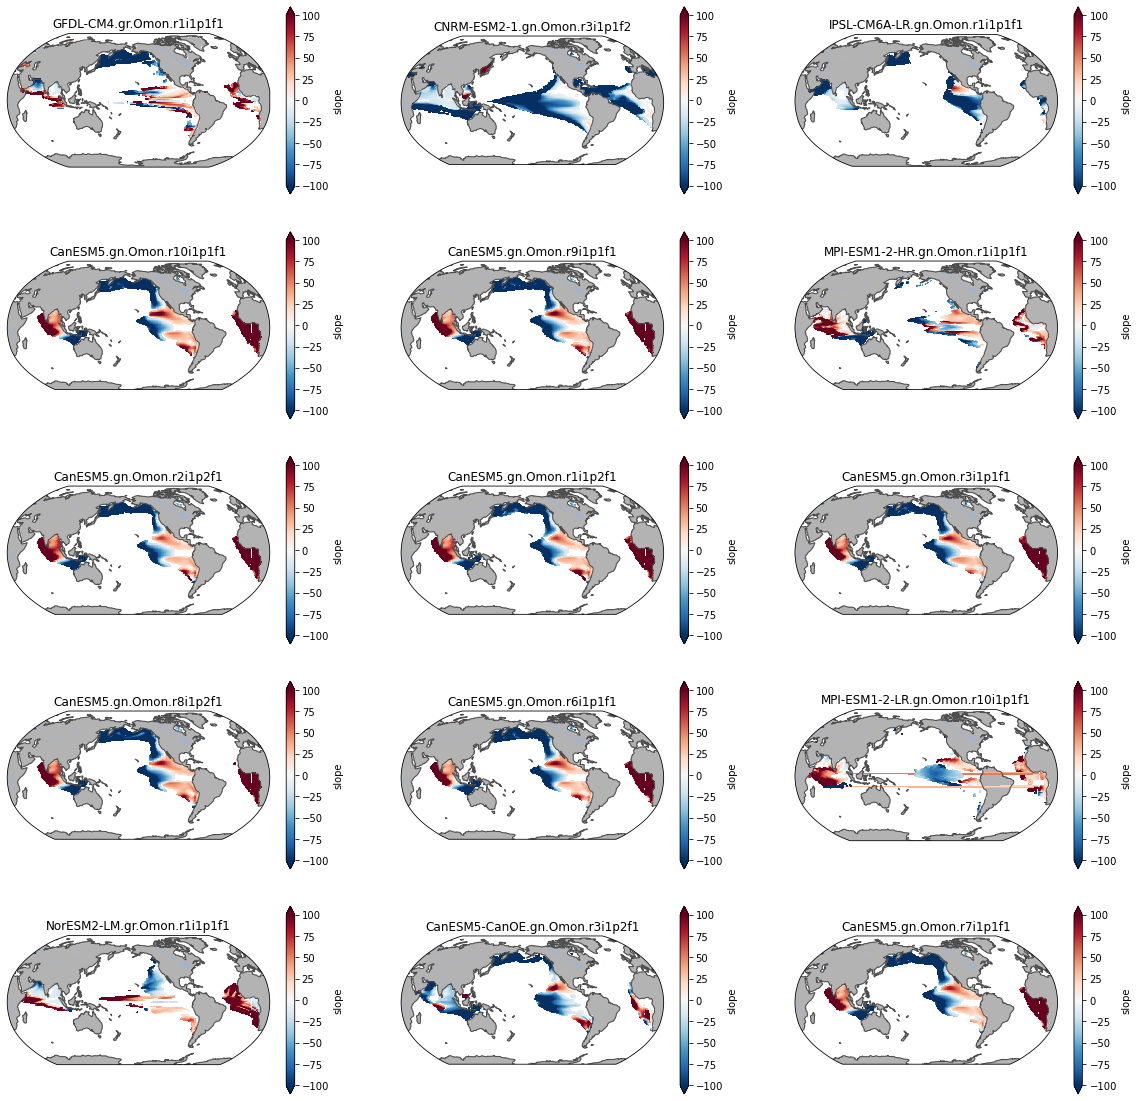

In [75]:
%matplotlib inline
fig, axarr = plt.subplots(figsize=[20, 20], ncols=3, nrows=5, subplot_kw={'projection':ccrs.Robinson(205)})

datasets = 
for ax, (name, oc) in zip(axarr.flat, boundary_dict.items()):
    print(name)
    
    
    

    
#     # also take out deep omz values
#     oc = oc.where(oc.upper_boundary < 500)
    
    
    trend.slope.plot(ax=ax, vmax=100, transform=ccrs.PlateCarree(), x='lon', y='lat')
    
    
    map_util_plot(ax)
    ax.set_title(name)

## Ever so quick detrending check


In [15]:
ddict_full_run_test = concat_experiments(ddict)
ddict_full_run_test = pick_first_member(ddict_full_run_test) # dont print all members here...

/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:122: UserWarning: CMIP.NOAA-GFDL.GFDL-CM4.historical.r1i1p1f1.Omon.gr.none failed to combine with :object of type 'int' has no len()
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:122: UserWarning: CMIP.NCC.NorCPM1.historical.r6i1p1f1.Omon.gr.none failed to combine with :list index out of range
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:122: UserWarning: CMIP.HAMMOZ-Consortium.MPI-ESM-1-2-HAM.historical.r2i1p1f1.Omon.gn.none failed to combine with :list index out of range
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")


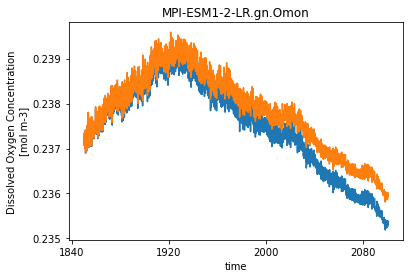

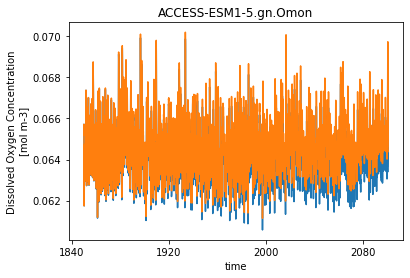

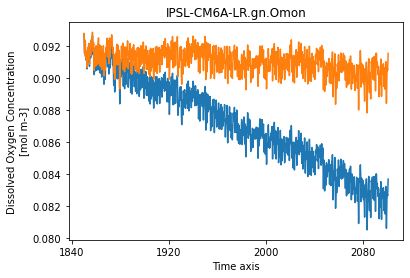

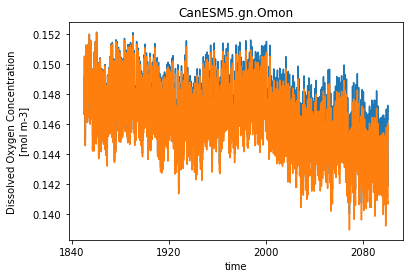

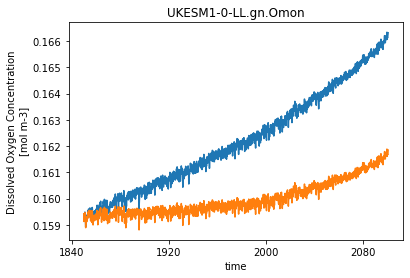

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:40204 -> tcp://127.0.0.1:37664
Traceback (most recent call last):
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/tornado/iostream.py", line 867, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/tornado/iostream.py", line 1140, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/distributed/worker.py", line 1428, in get_data
    response = await comm.read(deserializers=serializers)
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz

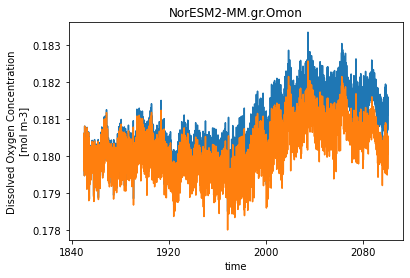

distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:37664
Traceback (most recent call last):
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/distributed/comm/tcp.py", line 376, in connect
    stream = await self.client.connect(
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/tornado/tcpclient.py", line 275, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/asyncio/tasks.py", line 492, in wait_for
    fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-pa

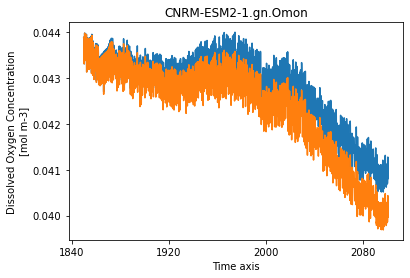

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:44886
Traceback (most recent call last):
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/tornado/iostream.py", line 867, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/tornado/iostream.py", line 1140, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/distributed/worker.py", line 2327, in gather_dep
    response = await get_data_from_worker(
  File "/

KilledWorker: ("('concatenate-sub-getitem-7e01e499d7c9eeb6a5ee1b933c67fb50', 6)", <WorkerState 'tcp://127.0.0.1:35726', name: 1, memory: 0, processing: 86>)

distributed.core - ERROR - None
Traceback (most recent call last):
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/distributed/core.py", line 575, in handle_stream
    handler(**merge(extra, msg))
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/distributed/scheduler.py", line 4821, in client_releases_keys
    self.transitions(recommendations)
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/distributed/scheduler.py", line 6753, in transitions
    self.send_all(client_msgs, worker_msgs)
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/distributed/scheduler.py", line 5335, in send_all
    w = stream_comms[worker]
KeyError: None
distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/distribu

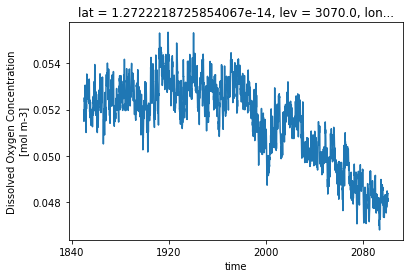

In [16]:
import matplotlib.pyplot as plt

for k in ddict_full_run.keys():
    
    ds_raw = ddict_full_run_test[k]
    ds_detrended = ddict_full_run[k]
    
    
    roi = {'x':len(ds_raw.x)//2, 'y':len(ds_raw.y)//2}
    
    plt.figure()
    ds_raw[ds_raw.attrs['variable_id']].isel(**roi).sel(lev=3000, method='nearest').plot()
    ds_detrended[ds_detrended.attrs['variable_id']].isel(**roi).sel(lev=3000, method='nearest').plot()
    plt.title(k)
    plt.show()